### Business Problem: Crop Disease Detection
Plant diseases can significantly impact agricultural productivity, leading to financial losses for farmers. Early and accurate disease detection is essential for taking timely action to prevent crop damage. This project aims to develop an AI-powered plant disease detection system using deep learning. By leveraging a **ResNet50V2** model, we classify plant diseases based on leaf images and provide insights to farmers for better crop management.


### Importing Required Libraries

In [1]:
import os
import json
import numpy as np
import tensorflow as tf
from zipfile import ZipFile
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab import files

### Data Exploration

In [2]:
# Load Kaggle Credentials and Set up API
kaggle_credentials = json.load(open('/content/kaggle (1).json'))
os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

In [3]:
# Download and Extract Dataset
!kaggle datasets download -d mohitsingh1804/plantvillage
with ZipFile('/content/plantvillage.zip', 'r') as zip_ref:
    zip_ref.extractall()

Dataset URL: https://www.kaggle.com/datasets/mohitsingh1804/plantvillage
License(s): GPL-2.0


In [4]:
# Dataset Paths and Image Parameters
train_data = '/content/PlantVillage/train'
val_data = '/content/PlantVillage/val'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [5]:
# Setting up Data Generators with Augumentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)
val_datagen = ImageDataGenerator(rescale=1.0/255)

## Training Data Generator
train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

## Validation Data Generator
val_generator = val_datagen.flow_from_directory(
    val_data,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

Found 43444 images belonging to 38 classes.
Found 10861 images belonging to 38 classes.


### Visualize Sample Images

In [6]:
# Get a batch of images and labels
images, labels = next(train_generator)

# Get class labels mapping (index to class name)
class_indices = train_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

if labels.ndim > 1:
    labels = np.argmax(labels, axis=1)

15: Orange___Haunglongbing_(Citrus_greening)
16: Peach___Bacterial_spot
33: Tomato___Spider_mites Two-spotted_spider_mite
30: Tomato___Late_blight
24: Soybean___healthy


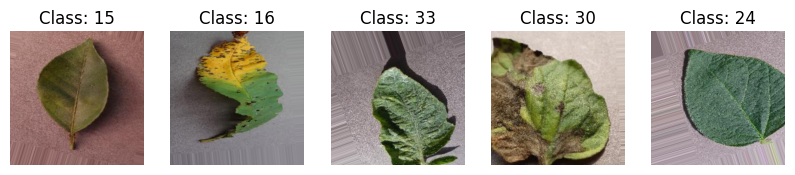

In [7]:
# Display first 5 images
plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    class_label = int(labels[i])
    class_name = index_to_class[class_label]
    print(f"{class_label}: {class_name}")
    plt.imshow(images[i])
    plt.title(f"Class: {class_label}")
    plt.axis("off")
plt.show()

### Model Building(ResNet50V2)

In [8]:
# Load Pretrained ResNet50V2
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [9]:
# Adding custom classification layers

## Pooling Layer
x = GlobalAveragePooling2D()(base_model.output)

## Dense Layer
x = Dense(256, activation='relu')(x)

## Dropout
x = Dropout(0.5)(x)

## O/P Layer
output_layer = Dense(len(class_indices), activation='softmax')(x)

In [10]:
# Compiling the Model
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Training the Model
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 600s 431ms/step - accuracy: 0.4415 - loss: 2.1997 - val_accuracy: 0.8472 - val_loss: 0.5814
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 564s 416ms/step - accuracy: 0.7675 - loss: 0.7838 - val_accuracy: 0.8873 - val_loss: 0.3826
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 571s 420ms/step - accuracy: 0.8268 - loss: 0.5732 - val_accuracy: 0.9094 - val_loss: 0.3101
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 574s 422ms/step - accuracy: 0.8487 - loss: 0.4884 - val_accuracy: 0.9155 - val_loss: 0.2713
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 587s 432ms/step - accuracy: 0.8631 - loss: 0.4345 - val_accuracy: 0.9270 - val_loss: 0.2346
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 570s 419ms/step - accuracy: 0.8818 - loss: 0.3820 - val_accuracy: 0.9309 - val_loss: 0.2168
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 556s 409ms/step - accuracy: 0.8867 - loss: 0.3588 - val_accuracy: 0.9359 - val_loss: 0.2040
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 593s 437ms/step - ac

In [20]:
# Validation Accuracy of the Model
model.evaluate(val_generator)

340/340 ━━━━━━━━━━━━━━━━━━━━ 32s 81ms/step - accuracy: 0.9419 - loss: 0.1835


[0.1793868988752365, 0.941810131072998]

### Plotting Training and Validation Performance

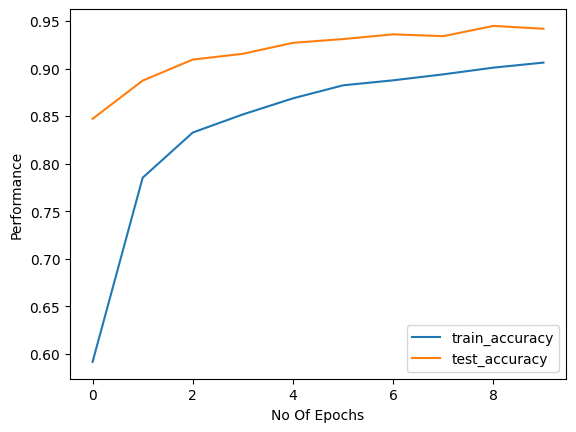

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('No Of Epochs')
plt.ylabel('Performance')
plt.legend(['train_accuracy', 'test_accuracy'])
plt.show()

### Saving the Model and Class Indices

In [36]:
model.save('plant_disease_model.h5')
joblib.dump(class_indices,'class_indices.pkl')

['class_indices.pkl']

In [39]:
# Downloading the saved model and class_indices
from google.colab import drive
drive.mount('/content/drive')

!cp plant_disease_model.h5 /content/drive/MyDrive/
!cp class_indices.pkl /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Building a Predictive System

In [21]:
# Load the saved model and class indices
model = load_model("plant_disease_model.h5")
class_indices = joblib.load("class_indices.pkl")

# Class name mapping
index_to_class = {v: k for k, v in class_indices.items()}

In [32]:
# Function to preprocess an image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Prediction function
def predict(image_array):
    prediction = model.predict(image_array)
    predicted_label = np.argmax(prediction)
    class_name = index_to_class[predicted_label]
    confidence = np.max(prediction)

    print(f"Predicted Class: {class_name} (Confidence: {confidence:.2f})")
    return class_name, confidence


In [34]:
# Example Usage
image_path = "/content/7ce1f8c1-1542-4d7b-be27-11e29d572283___GH_HL Leaf 508.2.JPG"
image_array = preprocess_image(image_path)
predict(image_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Class: Tomato___healthy (Confidence: 1.00)


('Tomato___healthy', np.float32(0.99991465))